In [1]:

import time
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from numba import jit,int8,float32,float64
tqdm.pandas()

from Back_Testing.TradeSim import *
from Strategy.Performance_Evaluation import *
from Data.data_pulling import *
from Strategy.signal_rongbin import *
import matplotlib.pyplot as plt
plt.style.use('seaborn')


In [2]:
ticker_list=['GOOG','YELP','QQQ']

time_slice=('09:40','15:50')
freq='100ms'
init_capital=10**6

opt_params_dict={'CB':{"GOOG":(20,0.005),'YELP':(80,0.0075),'QQQ':(10,0.0025)},
                 
                 
                 }



cb_params_dict=opt_params_dict['CB']

## 1.Load Data

In [5]:
tot_order_book_dict={}
for ticker in ticker_list:
    df=pd.read_csv('./Data/%s_order_book.csv'%(ticker))
    
    df.set_index('Time',inplace=True)
    df.index=pd.to_datetime(df.index)
    #df=df.between_time(time_slice[0],time_slice[1])
  
    df=df.groupby(df.index.date,group_keys=False,as_index=False).apply(
        lambda x: clean_order_book(x,time_slice,freq='100ms'))
    tot_order_book_dict[ticker]=df

In [16]:

def summarize_order_book(tot_order_book_dict,ticker_list,depth=5):
    
    
    cols=['Ticker','num quotes(M)','quotes/sec','avg(price)']      
    for i in range(1,depth+1):
        cols.extend(['avg(half_rl_spread%%_%d)'%(i),'avg(dollar_volume_%d)'%i])
    tot_list=[]
    
    for i,ticker in enumerate(ticker_list):
        ticker_order_book=tot_order_book_dict[ticker]
        avg_price=ticker_order_book['mid_quote'].mean()
        'get  bid-ask spread'
        spread_list=[]
        volume_list=[]
        for j in range(1,depth+1):    
            sp_ts=ticker_order_book['ask_price%d'%(j)]-ticker_order_book['bid_price%d'%(j)]
            size_ts=ticker_order_book['ask_size%d'%(j)]+ticker_order_book['bid_size%d'%(j)]
            rl_sp=sp_ts.mean()*10**4/avg_price
            spread_list.append(round(rl_sp,2))
            volume_list.append(round(size_ts.mean()*avg_price/2,1))
        
        

        'total bid ask size and mid quote'
    
    
        #quote_sec_mean=order_book_ex_df.resample('1s')['mid_quote'].count().mean()
        day_num=len(np.unique(ticker_order_book.index.date))
        quote_sec_mean=len(ticker_order_book)/(6*60*60*day_num)
        num_quote=len(ticker_order_book)/10**6
        
        
        
        record=[ticker,round(num_quote,1),round(quote_sec_mean,2),round(avg_price,2)]
        for j in range(depth):
            record.extend([spread_list[j],volume_list[j]])
            
        tot_list.append(record)
    ob_sm_df=pd.DataFrame(tot_list,columns=cols,index=ticker_list)
    return ob_sm_df

In [17]:
ob_sm_df=summarize_order_book(tot_order_book_dict,ticker_list)
ob_sm_df.T

,GOOG,YELP,QQQ
Ticker,GOOG,YELP,QQQ
num quotes(M),2.0,2.0,2.0
quotes/sec,10.28,10.28,10.28
avg(price),925.66,42.49,143.9
avg(half_rl_spread%_1),4.17,9.7,0.75
avg(dollar_volume_1),105822.6,8193.4,518856.8
avg(half_rl_spread%_2),5.56,16.82,2.14
avg(dollar_volume_2),90643.3,8819.5,1166353.2
avg(half_rl_spread%_3),6.97,22.89,3.53
avg(dollar_volume_3),74350.9,9285.1,1107249.9


In [20]:
tmp1=[col for col in ob_sm_df.columns if 'spread' in col]
tmp1

['avg(half_rl_spread%_1)',
 'avg(half_rl_spread%_2)',
 'avg(half_rl_spread%_3)',
 'avg(half_rl_spread%_4)',
 'avg(half_rl_spread%_5)']

In [22]:
tmp=ob_sm_df[tmp1].T
tmp

,GOOG,YELP,QQQ
avg(half_rl_spread%_1),4.17,9.70,0.75
avg(half_rl_spread%_2),5.56,16.82,2.14
avg(half_rl_spread%_3),6.97,22.89,3.53
avg(half_rl_spread%_4),8.15,28.45,4.92
avg(half_rl_spread%_5),9.21,33.89,6.31


In [25]:
tmp2=-tmp.cumsum()/100
tmp2

,GOOG,YELP,QQQ
avg(half_rl_spread%_1),-0.0417,-0.0970,-0.0075
avg(half_rl_spread%_2),-0.0973,-0.2652,-0.0289
avg(half_rl_spread%_3),-0.1670,-0.4941,-0.0642
avg(half_rl_spread%_4),-0.2485,-0.7786,-0.1134
avg(half_rl_spread%_5),-0.3406,-1.1175,-0.1765


<AxesSubplot:title={'center':'Price-Impact'}, ylabel='Cumulative cost of liquidity(%)'>

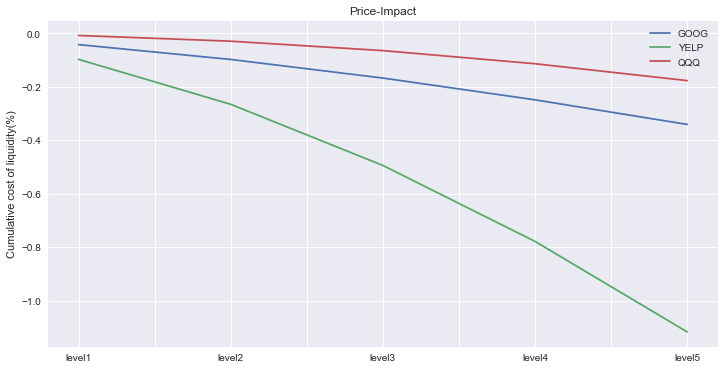

In [28]:
tmp2.index=['level%d'%(i) for i in range(1,6)]

tmp2.plot(title='Price-Impact',ylabel='Cumulative cost of liquidity(%)',figsize=(12,6))

## 2.Signal Functions

### 2.1 Channel Breakout

In [7]:

def test_CB_performance(ticker_order_book,ChnLen=pd.offsets.Second(30*20),StpPct=0.005,init_capital=10**6,delay=None,base_freqstr='100ms',slpg=0):
    """test Channel Breakout peformance for one stock
    

    Parameters
    ----------
    ticker_order_book : TYPE
        total order book of one stock.
    ChnLen : TYPE, optional
        DESCRIPTION. The default is pd.offsets.Second(30*20).
    StpPct : TYPE, optional
        DESCRIPTION. The default is 0.005.
    init_capital : TYPE, optional
        DESCRIPTION. The default is 10**6.
    delay : TYPE, optional
        DESCRIPTION. The default is None.
    base_freqstr : TYPE, optional
        DESCRIPTION. The default is '100ms'.
    slpg : TYPE, optional
        DESCRIPTION. The default is 0.

    Returns
    -------
    res : TYPE
        DESCRIPTION.

    """
    
    daily_groupby=ticker_order_book.groupby(ticker_order_book.index.floor('D'))
    
    date_range=list(daily_groupby.groups.keys())
    #print('data date range: ',date_range)
    trade_res_list=[]
    equity_res_list=[]
    cum_pnl=0
    for j,dt in enumerate(date_range):
        order_book_tmp=daily_groupby.get_group(dt)
    
        signal_ts=generate_cb_signal(order_book_tmp,ChnLen, StpPct=StpPct)
        tradesim=DailyTradeSettle(order_book_tmp,init_capital,base_freqstr=base_freqstr,delay=delay,slpg=slpg)
    
        tradesim_res=tradesim.simple_tradesim(signal_ts,eval_freq=pd.offsets.Second(30))    
        
        trade_detail_df=tradesim_res['trade_detail']
        equity_df=tradesim_res['equity']
        day_pnl=equity_df['equity'].iloc[-1]-equity_df['equity'].iloc[0]
        #adjust equity
        equity_df['equity']=equity_df['equity']+cum_pnl
        cum_pnl=cum_pnl+day_pnl
        trade_res_list.append(trade_detail_df)
        equity_res_list.append(equity_df)
        
        
    tot_trade_df=pd.concat(trade_res_list,axis=0)
    tot_equity_df=pd.concat(equity_res_list,axis=0)
        
    tot_pnl=tot_trade_df['profit'].sum()
    tot_ret=tot_pnl/init_capital
    
    print('Final profit: ',cum_pnl)
    print('Final Total return: %.2f %%'%(np.round(tot_ret,4)*100))
    
    res={'trade_detail':tot_trade_df,'equity':tot_equity_df}
    res['total_return']=tot_ret
    return res
    




def get_CB_total_results(tot_order_book_dict,ticker_list,params_dict,init_capital=10**6,eval_freq='5min'):
    """ GET CB results on all stocks returen dict on equity df, eval df and trade detail df
    

    Parameters
    ----------
    tot_order_book_dict : TYPE
        DESCRIPTION.
    ticker_list : TYPE
        DESCRIPTION.
    params_dict : TYPE
        DESCRIPTION.
    init_capital : TYPE, optional
        DESCRIPTION. The default is 10**6.
    eval_freq : TYPE, optional
        DESCRIPTION. The default is '5min'.

    Returns
    -------
    cb_res_df : TYPE
        DESCRIPTION.
    cb_trade_dict : TYPE
        DESCRIPTION.
    cb_equity_dict : TYPE
        DESCRIPTION.

    """
    cb_res_df=pd.DataFrame()
    cb_trade_dict={}
    cb_equity_dict={}
    for i,ticker in enumerate(ticker_list):
    
        print("Choose stock: ",ticker)
        ticker_order_book=tot_order_book_dict[ticker]
        
        opt_len,opt_pct=params_dict[ticker]
        print("Optimal params: ",(opt_len,opt_pct))
        
        ticker_res=test_CB_performance(ticker_order_book,ChnLen=pd.offsets.Second(30*opt_len),StpPct=opt_pct,init_capital=init_capital,delay=None)
        
        tot_trade_df=ticker_res['trade_detail']
        tot_equity_df=ticker_res['equity']
        tot_equity_df['mid_quote']=(tot_equity_df['bid_price1']+tot_equity_df['ask_price1'])/2
        tot_equity_df['benchmark']=tot_equity_df['mid_quote']/tot_equity_df['mid_quote'].iloc[0]*init_capital
    
        
    
        res_df=Eval_strategy_Performance(tot_equity_df, tot_trade_df, eval_freq)
    
        res_df.rename(columns={'Value':ticker},inplace=True)
        
        cb_res_df=pd.concat([cb_res_df,res_df],axis=1)
        
        cb_trade_dict[ticker]=tot_trade_df
        cb_equity_dict[ticker]=tot_equity_df
    return cb_res_df,cb_trade_dict,cb_equity_dict


### 2.2

### 2.3

### 3.3 Visulization

In [8]:

def plot_equity_curve(tot_equity_df,ticker,opt_params,signal_name='HFT',ax=None,init_capital=10**6):
    """

    Parameters
    ----------
    tot_equity_df : TYPE
        DESCRIPTION.
    ticker : TYPE
        DESCRIPTION.
    opt_params : TYPE
        DESCRIPTION.
    signal_name : TYPE, optional
        DESCRIPTION. The default is 'HFT'.
    ax : TYPE, optional
        DESCRIPTION. The default is None.
    init_capital : TYPE, optional
        DESCRIPTION. The default is 10**6.

    Returns
    -------
    None.

    """
    
    
    if 'benchmark' not in tot_equity_df.columns:
        tot_equity_df['mid_quote']=(tot_equity_df['bid_price1']+tot_equity_df['ask_price1'])/2
        tot_equity_df['benchmark']=tot_equity_df['mid_quote']/tot_equity_df['mid_quote'].iloc[0]*init_capital
        
    
    if ax is None:
        fig,ax=plt.subplots(figsize=(12,6))
        
    equity_arr=tot_equity_df['equity'].to_numpy()
    tot_ret=(equity_arr[-1]-equity_arr[0])/equity_arr[0]
    
    x=np.arange(len(tot_equity_df))
    
    t0=tot_equity_df.index.date[0]
    t1=tot_equity_df.index.date[-1]
    
    
    ax.plot(x,equity_arr,label=signal_name)
    ax.plot(x,tot_equity_df['benchmark'].values,label='Buy and hold')
    ax.legend()
    title_str="Equity curve on %s"%(ticker)
    opt_params=[str(i) for i in opt_params]
    title_str=title_str+' Opt params: '+','.join(opt_params)
    ax.set_title(title_str)
    text_str="Total return: %.2f %%. \n %s to %s"%((tot_ret*100),t0,t1)
    ax.text(0.25,0.95,text_str,transform=ax.transAxes, fontsize=10, verticalalignment='top')


    
    

## 3. Strategy Results

### 3.1 CB

In [9]:
cb_res_df,cb_trade_dict,cb_equity_dict=get_CB_total_results(tot_order_book_dict,ticker_list,cb_params_dict,init_capital=init_capital)
cb_res_df

Choose stock:  GOOG
Optimal params:  (20, 0.005)


C:\ProgramData\Anaconda3\lib\site-packages\numba\core\dispatcher.py:241: UserWarning: Numba extension module 'numba_scipy' failed to load due to 'ValueError(No function '__pyx_fuse_0pdtr' found in __pyx_capi__ of 'scipy.special.cython_special')'.
  entrypoints.init_all()


2017-08-24
has any signal:  True
Day return:  -0.0067
2017-08-25
has any signal:  True
Day return:  -0.0006
2017-08-28
has any signal:  True
Day return:  0.0005
2017-08-29
has any signal:  True
Day return:  0.0118
2017-08-30
has any signal:  True
Day return:  0.0039
2017-08-31
has any signal:  True
Day return:  0.0018
2017-09-01
has any signal:  True
Day return:  -0.0072
2017-09-05
has any signal:  True
Day return:  0.0011
2017-09-06
has any signal:  True
Day return:  0.0045
Final profit:  9011.033231048263
Final Total return: 0.90 %
Choose stock:  YELP
Optimal params:  (80, 0.0075)
2017-08-24
has any signal:  True
Day return:  -0.0045
2017-08-25
has any signal:  True
Day return:  -0.0049
2017-08-28
has any signal:  True
Day return:  -0.0014
2017-08-29
has any signal:  True
Day return:  0.0091
2017-08-30
has any signal:  True
Day return:  -0.0075
2017-08-31
has any signal:  True
Day return:  0.0089
2017-09-01
has any signal:  True
Day return:  -0.0008
2017-09-05
has any signal:  True
D

,GOOG,YELP,QQQ
Performance Evaluation,,,
Series Date Start,2017-08-24 09:40:00,2017-08-24 09:40:00,2017-08-24 09:40:00
Series Date End,2017-09-06 15:45:00,2017-09-06 15:45:00,2017-09-06 15:45:00
Net Equity,1009011.033231,994606.926892,1036651.5742
Net Profit,9011.033231,-5393.073108,36651.5742
Total Return,0.009011,-0.005393,0.036652
Annual Compounded Return,0.25,-0.15,1.01
Annualized Std Dev,0.1005,0.1818,0.0834
Worst Relative Drawdown,0.02,0.02,0.01
Average Relative Drawdown,0.01,0.01,0.0


In [31]:
101850/10/60/60

2.8291666666666666

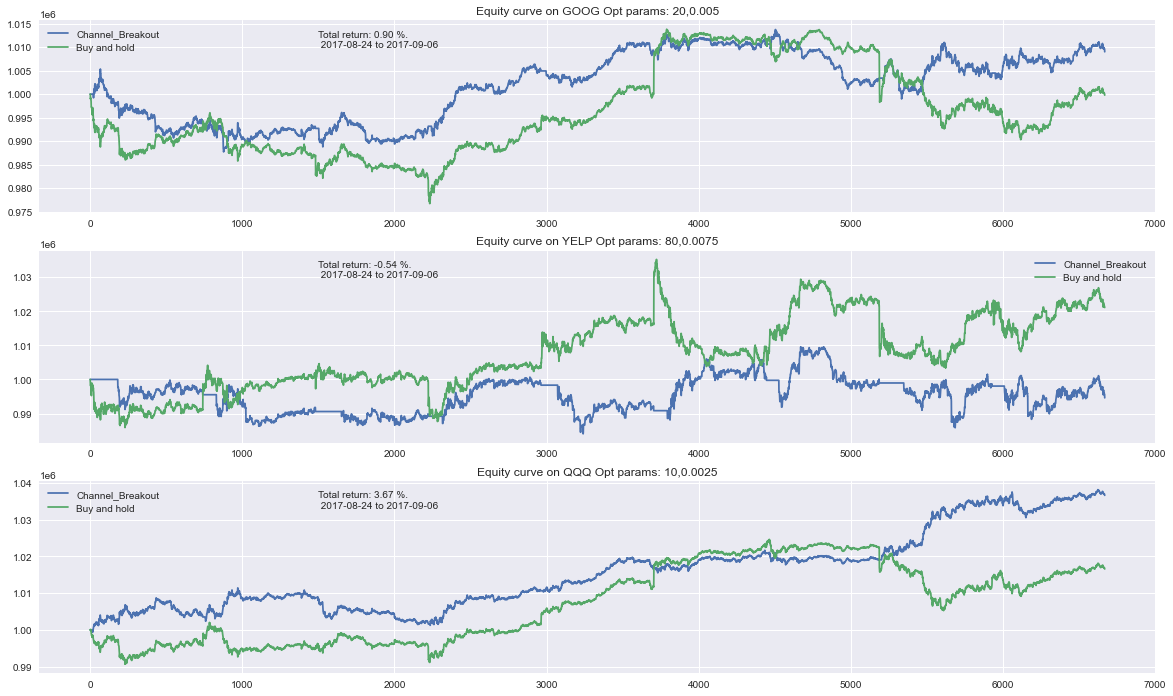

In [10]:

fig,axes=plt.subplots(3,1,figsize=(20,12))

for i,ticker in enumerate(ticker_list):
    
    tot_equity_df=cb_equity_dict[ticker]

    plot_equity_curve(tot_equity_df,ticker,cb_params_dict[ticker],signal_name='Channel_Breakout',ax=axes[i])






## 4 Cost of delay

In [11]:
delay_list=[None,pd.offsets.Milli(100),pd.offsets.Second(1),pd.offsets.Second(2),pd.offsets.Second(3),pd.offsets.Second(4)]
delay_str_list=['0','100ms','1s','2s','3s','4s']


In [12]:
def get_full_delay_results(signal_name,signal_params_dict,signal_equity_dict,signal_res_df,delay_list,delay_str_list,ticker_list,tot_order_book_dict):

    
    
    delay_res_dict={}
    delay_cost_df=pd.DataFrame()
    print('Signal: ',signal_name)
    for i,ticker in enumerate(ticker_list):
    
        print("Choose stock: ",ticker)
        ticker_order_book=tot_order_book_dict[ticker]
        
        'get your optimal params'
        opt_len,opt_pct=signal_params_dict[ticker]
        print("Optimal params: ",(opt_len,opt_pct))
        
        'get your optimal delay'
        no_delay_final_equity=signal_res_df.loc['Net Equity',ticker]
        
        
        delay_cost_list=[0]
        
        delay_res_df=signal_res_df[ticker].to_frame()
        
        for j,delay in enumerate(delay_list[1:]):
            
            'change your straegy performance here'
            if signal_name=='CB':
                ticker_res_delay=test_CB_performance(ticker_order_book,ChnLen=pd.offsets.Second(30*opt_len),StpPct=opt_pct,init_capital=10**6,delay=delay)
            elif signal_name=='SR':
                pass
            elif signal_name=='MA':
                pass
            
            delay_str=delay_str_list[j+1]
            print("Current delay: ",delay_str)
            
            delay_equity_df=ticker_res_delay['equity']
            delay_equity_ts=delay_equity_df['equity']
            
            
            signal_equity_dict[ticker]['equity_delay_%s'%(delay_str)]=delay_equity_ts
            
            
            res_df=Eval_strategy_Performance(delay_equity_df,ticker_res_delay['trade_detail'])
            res_df.rename(columns={'Value':'delay '+delay_str},inplace=True)
    
            delay_res_df=pd.concat([delay_res_df,res_df],axis=1)
            
            
            net_equity_delay=delay_equity_ts.iloc[-1]
            
            delay_loss=net_equity_delay/no_delay_final_equity-1
            delay_cost_list.append(delay_loss)
            
        delay_res_dict[ticker]=delay_res_df
        delay_s=pd.Series(delay_cost_list,index=delay_str_list)*100
        delay_cost_df[ticker]=delay_s
        



    delay_cost_df.index=delay_str_list
    return delay_cost_df,delay_res_dict


### 4.1 CB

In [13]:
cb_delay_cost_df,cb_delay_res_dict=get_full_delay_results(signal_name='CB',
                                                          signal_params_dict=cb_params_dict,
                                                          signal_equity_dict=cb_equity_dict,
                                                          signal_res_df=cb_res_df,
                                                          delay_list=delay_list,
                                                          delay_str_list=delay_str_list,
                                                          ticker_list=ticker_list,
                                                          tot_order_book_dict=tot_order_book_dict)



cb_delay_cost_df

Signal:  CB
Choose stock:  GOOG
Optimal params:  (20, 0.005)
2017-08-24
has any signal:  True
Day return:  -0.0066
2017-08-25
has any signal:  True
Day return:  -0.0006
2017-08-28
has any signal:  True
Day return:  0.0004
2017-08-29
has any signal:  True
Day return:  0.0118
2017-08-30
has any signal:  True
Day return:  0.0039
2017-08-31
has any signal:  True
Day return:  0.0018
2017-09-01
has any signal:  True
Day return:  -0.0074
2017-09-05
has any signal:  True
Day return:  0.0011
2017-09-06
has any signal:  True
Day return:  0.0046
Final profit:  8978.946118891006
Final Total return: 0.90 %
Current delay:  100ms
2017-08-24
has any signal:  True
Day return:  -0.0065
2017-08-25
has any signal:  True
Day return:  -0.0007
2017-08-28
has any signal:  True
Day return:  0.0007
2017-08-29
has any signal:  True
Day return:  0.0118
2017-08-30
has any signal:  True
Day return:  0.0039
2017-08-31
has any signal:  True
Day return:  0.0018
2017-09-01
has any signal:  True
Day return:  -0.0074
201

Day return:  0.0095
2017-08-30
has any signal:  True
Day return:  0.0056
2017-08-31
has any signal:  True
Day return:  0.004
2017-09-01
has any signal:  True
Day return:  -0.0019
2017-09-05
has any signal:  True
Day return:  0.0157
2017-09-06
has any signal:  True
Day return:  0.0022
Final profit:  36587.40667162184
Final Total return: 3.66 %
Current delay:  4s


,GOOG,YELP,QQQ
0,0.000000,0.000000,0.000000
100ms,-0.003180,-0.047665,-0.023474
1s,-0.063168,-0.168324,-0.099364
2s,-0.110200,-0.190297,-0.048954
3s,-0.139886,-0.186832,-0.078047
4s,-0.137327,-0.186207,-0.006190


<AxesSubplot:title={'center':'Channel-Breakout Strategy, Cost of delay on GOOG,YELP,QQQ'}, xlabel='time of delay', ylabel='Cost of delay (%)'>

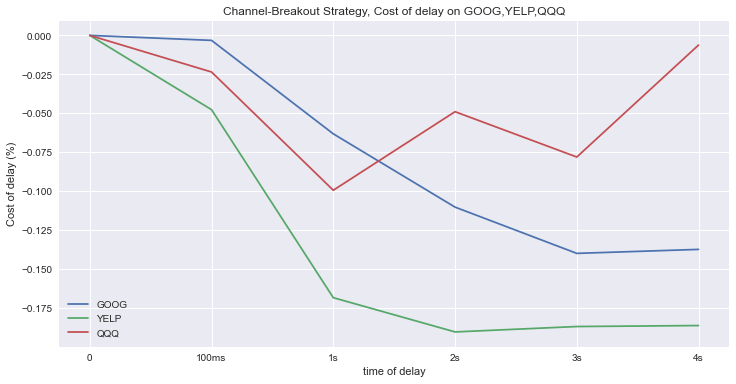

In [32]:
cb_delay_cost_df.plot(title='Channel-Breakout Strategy, Cost of delay on %s'%(','.join(ticker_list)),
                      figsize=(12,6),
                      xlabel='time of delay',
                      ylabel='Cost of delay (%)')



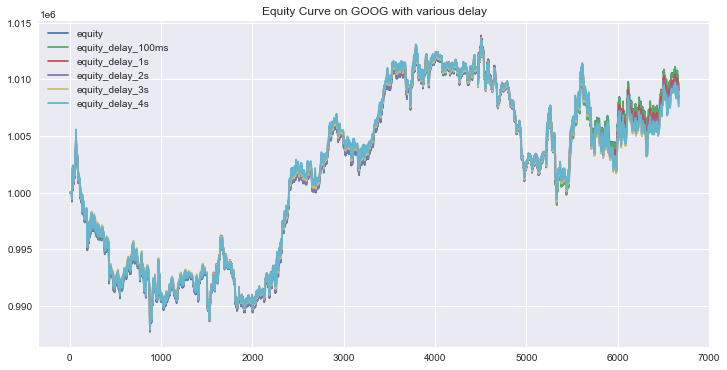

In [33]:

ticker='GOOG'
fig,ax=plt.subplots(figsize=(12,6))
tmp=cb_equity_dict[ticker].drop(columns=['mid_quote','pos_size','bid_price1','ask_price1','benchmark'])
tmp.index=pd.RangeIndex(len(tmp))
tmp.plot(ax=ax,title='Equity Curve on %s with various delay'%(ticker)) #secondary_y=['benchmark']
plt.show()

In [34]:
cb_delay_res_dict[ticker]

,GOOG,delay 100ms,delay 1s,delay 2s,delay 3s,delay 4s
Performance Evaluation,,,,,,
Series Date Start,2017-08-24 09:40:00,2017-08-24 09:40:00,2017-08-24 09:40:00,2017-08-24 09:40:00,2017-08-24 09:40:00,2017-08-24 09:40:00
Series Date End,2017-09-06 15:45:00,2017-09-06 15:45:00,2017-09-06 15:45:00,2017-09-06 15:45:00,2017-09-06 15:45:00,2017-09-06 15:45:00
Net Equity,1009011.033231,1008978.946119,1008373.661764,1007899.106833,1007599.568131,1007625.384892
Net Profit,9011.033231,8978.946119,8373.661764,7899.106833,7599.568131,7625.384892
Total Return,0.009011,0.008979,0.008374,0.007899,0.0076,0.007625
Annual Compounded Return,0.25,0.25,0.23,0.22,0.21,0.21
Annualized Std Dev,0.1005,0.1004,0.1009,0.1009,0.1011,0.101
Worst Relative Drawdown,0.02,0.02,0.02,0.02,0.02,0.02
Average Relative Drawdown,0.01,0.01,0.01,0.01,0.01,0.01


In [47]:
cor_metrics=[ 'Net Profit',
       'Total Return', 
       'Worst Relative Drawdown', 'Average Relative Drawdown',
        'Sharpe Ratio', 'Sortino Ratio',
       'Calmar Ratio', 'Total Return To Conditional Drawdown', 'Skewness',
         'Percent Winners(%) ', 'Percent Losers(%) ',
       'Winners Losers Ratio']
tmp=cb_delay_res_dict[ticker].loc[cor_metrics].copy()
tmp.loc['Total Return',:]=tmp.loc['Total Return',:]*100
tmp.round(2)

,GOOG,delay 100ms,delay 1s,delay 2s,delay 3s,delay 4s
Performance Evaluation,,,,,,
Net Profit,9011.033231,8978.946119,8373.661764,7899.106833,7599.568131,7625.384892
Total Return,0.901103,0.897895,0.837366,0.789911,0.759957,0.762538
Worst Relative Drawdown,0.02,0.02,0.02,0.02,0.02,0.02
Average Relative Drawdown,0.01,0.01,0.01,0.01,0.01,0.01
Sharpe Ratio,2.5,2.49,2.31,2.18,2.1,2.11
Sortino Ratio,2.46,2.46,2.27,2.15,2.06,2.07
Calmar Ratio,15.6,15.54,14.65,13.77,13.24,13.2
Total Return To Conditional Drawdown,0.63,0.63,0.6,0.56,0.53,0.54
Skewness,-0.11,-0.1,-0.15,-0.14,-0.14,-0.14


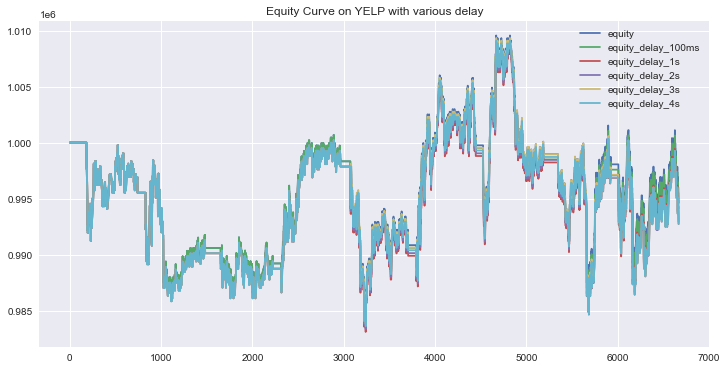

In [27]:

ticker='YELP'
fig,ax=plt.subplots(figsize=(12,6))
tmp=cb_equity_dict[ticker].drop(columns=['mid_quote','pos_size','bid_price1','ask_price1','benchmark'])
tmp.index=pd.RangeIndex(len(tmp))
tmp.plot(ax=ax,title='Equity Curve on %s with various delay'%(ticker)) #secondary_y=['benchmark']
plt.show()

In [28]:
cb_delay_res_dict[ticker]

,YELP,delay 100ms,delay 1s,delay 2s,delay 3s,delay 4s
Performance Evaluation,,,,,,
Series Date Start,2017-08-24 09:40:00,2017-08-24 09:40:00,2017-08-24 09:40:00,2017-08-24 09:40:00,2017-08-24 09:40:00,2017-08-24 09:40:00
Series Date End,2017-09-06 15:45:00,2017-09-06 15:45:00,2017-09-06 15:45:00,2017-09-06 15:45:00,2017-09-06 15:45:00,2017-09-06 15:45:00
Net Equity,994606.926892,994132.845167,992932.762495,992714.218406,992748.680461,992754.897233
Net Profit,-5393.073108,-5867.154833,-7067.237505,-7285.781594,-7251.319539,-7245.102767
Total Return,-0.005393,-0.005867,-0.007067,-0.007286,-0.007251,-0.007245
Annual Compounded Return,-0.15,-0.16,-0.2,-0.2,-0.2,-0.2
Annualized Std Dev,0.1818,0.1822,0.1835,0.1839,0.1841,0.1842
Worst Relative Drawdown,0.02,0.02,0.02,0.02,0.02,0.02
Average Relative Drawdown,0.01,0.01,0.01,0.01,0.01,0.01


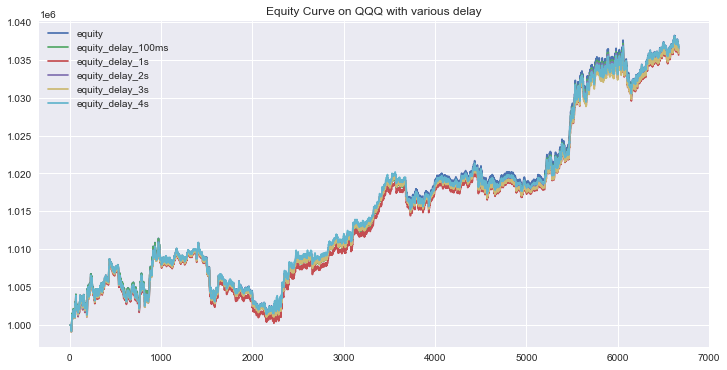

In [29]:
ticker='QQQ'
fig,ax=plt.subplots(figsize=(12,6))
tmp=cb_equity_dict[ticker].drop(columns=['mid_quote','pos_size','bid_price1','ask_price1','benchmark'])
tmp.index=pd.RangeIndex(len(tmp))
tmp.plot(ax=ax,title='Equity Curve on %s with various delay'%(ticker)) #secondary_y=['benchmark']
plt.show()

In [30]:
cb_delay_res_dict[ticker]

,QQQ,delay 100ms,delay 1s,delay 2s,delay 3s,delay 4s
Performance Evaluation,,,,,,
Series Date Start,2017-08-24 09:40:00,2017-08-24 09:40:00,2017-08-24 09:40:00,2017-08-24 09:40:00,2017-08-24 09:40:00,2017-08-24 09:40:00
Series Date End,2017-09-06 15:45:00,2017-09-06 15:45:00,2017-09-06 15:45:00,2017-09-06 15:45:00,2017-09-06 15:45:00,2017-09-06 15:45:00
Net Equity,1036651.5742,1036408.233241,1035621.513238,1036144.09594,1035842.498319,1036587.406672
Net Profit,36651.5742,36408.233241,35621.513238,36144.09594,35842.498319,36587.406672
Total Return,0.036652,0.036408,0.035622,0.036144,0.035842,0.036587
Annual Compounded Return,1.01,1.0,0.98,0.99,0.99,1.01
Annualized Std Dev,0.0834,0.0835,0.0838,0.0834,0.0834,0.0835
Worst Relative Drawdown,0.01,0.01,0.01,0.01,0.01,0.01
Average Relative Drawdown,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:



cap_list=[10**3,10**4,10**5,10**6]
cap_str_list=['1K','10K','100K','1M']


impact_res_dict={}
impact_cost_df=pd.DataFrame()

for i,ticker in enumerate(ticker_list):

    print("Choose stock: ",ticker)
    ticker_order_book=tot_order_book_dict[ticker]
    
    'get your optimal params'
    opt_len,opt_pct=cb_params_dict[ticker]
    print("Optimal params: ",(opt_len,opt_pct))
    

    
    cap_res_df=pd.DataFrame()
    impact_cost_list=[]
    for j,cap in enumerate(cap_list):
        
 
        ticker_res_cap=test_CB_performance(ticker_order_book,ChnLen=pd.offsets.Second(30*opt_len),StpPct=opt_pct,init_capital=cap,delay=None)

        
        cap_str=cap_str_list[j]
        print("Current cap: ",cap_str)
        
        cap_equity_df=ticker_res_cap['equity']
        cap_equity_ts=cap_equity_df['equity']
        
        
        cb_equity_dict[ticker]['init_cap_%s'%(cap_str)]=cap_equity_ts
        
        
        res_df=Eval_strategy_Performance(cap_equity_df,ticker_res_cap['trade_detail'])
        res_df.rename(columns={'Value':'Capital '+cap_str},inplace=True)

        cap_res_df=pd.concat([cap_res_df,res_df],axis=1)
        
        
        net_equity_cap=cap_equity_ts.iloc[-1]
        
        
        impact_cost_list.append(net_equity_cap/cap)
        
    impact_res_dict[ticker]=cap_res_df
    impact_s=pd.Series(impact_cost_list,index=cap_str_list)
    impact_cost_df[ticker]=impact_s
    


Choose stock:  GOOG
Optimal params:  (20, 0.005)
2017-08-24
has any signal:  True
Day return:  -0.0043
2017-08-25
has any signal:  True
Day return:  0.0005
2017-08-28
has any signal:  True
Day return:  0.0013
2017-08-29
has any signal:  True
Day return:  0.0122
2017-08-30
has any signal:  True
Day return:  0.0044
2017-08-31
has any signal:  True
Day return:  0.0019
2017-09-01
has any signal:  True
Day return:  -0.0063
2017-09-05
has any signal:  True
Day return:  0.0024
2017-09-06
has any signal:  True
Day return:  0.0055
Final profit:  17.64299895189265
Final Total return: 1.76 %
Current cap:  1K
2017-08-24
has any signal:  True
Day return:  -0.0043
2017-08-25
has any signal:  True
Day return:  0.0003
2017-08-28
has any signal:  True
Day return:  0.0013
2017-08-29
has any signal:  True
Day return:  0.0122
2017-08-30
has any signal:  True
Day return:  0.0044
2017-08-31
has any signal:  True
Day return:  0.0019
2017-09-01
has any signal:  True
Day return:  -0.0066
2017-09-05
has any sig

In [50]:
cb_cap_cost_df=impact_cost_df.copy()

for i in range(len(impact_cost_df)):
    cb_cap_cost_df.iloc[i,:]=(cb_cap_cost_df.iloc[i,:]/impact_cost_df.iloc[0,:]-1)*100

cb_cap_cost_df

,GOOG,YELP,QQQ
1K,0.000000,0.000000,0.000000e+00
10K,-0.049248,-0.267463,-4.440892e-14
100K,-0.190541,-2.276490,-5.629697e-03
1M,-0.848231,-2.862617,-2.122133e-01


<AxesSubplot:title={'center':'Channel-Breakout Strategy, cost of price impact on GOOG,YELP,QQQ'}, xlabel='Trading Capital', ylabel='Cost of price impact (%)'>

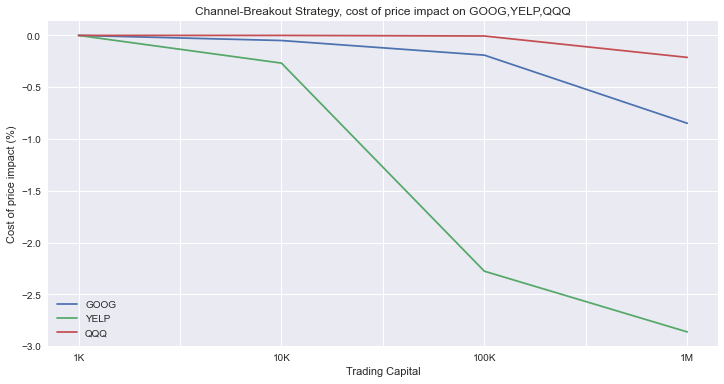

In [51]:
cb_cap_cost_df.plot(title='Channel-Breakout Strategy, cost of price impact on %s'%(','.join(ticker_list)),
                      figsize=(12,6),
                      xlabel='Trading Capital',
                      ylabel='Cost of price impact (%)')



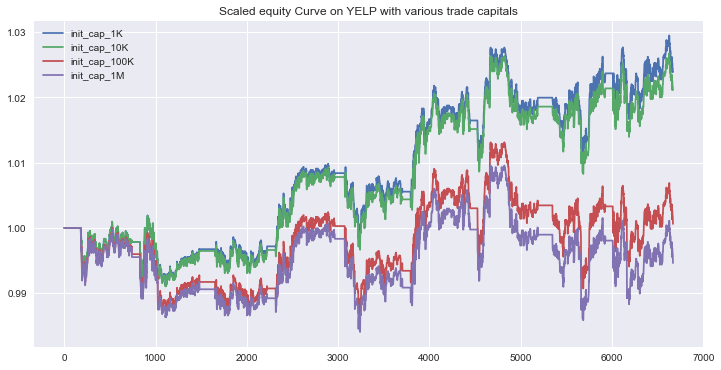

In [57]:
ticker='YELP'
tmp_col=['init_cap_1K','init_cap_10K','init_cap_100K','init_cap_1M']
fig,ax=plt.subplots(figsize=(12,6))
tmp=cb_equity_dict[ticker][tmp_col]
tmp2=tmp.apply(lambda ts: ts/ts.iloc[0])
tmp2.index=pd.RangeIndex(len(tmp))
tmp2.plot(ax=ax,title='Scaled equity Curve on %s with various trade capitals'%(ticker)) #secondary_y=['benchmark']
plt.show()

In [58]:

cor_metrics=[ 'Net Profit',
       'Total Return', 
       'Worst Relative Drawdown', 'Average Relative Drawdown',
        'Sharpe Ratio', 'Sortino Ratio',
       'Calmar Ratio','Average Trade Size','Average Depth',
         'Percent Winners(%) ', 'Percent Losers(%) ',
       'Winners Losers Ratio']


tmp=impact_res_dict[ticker].loc[cor_metrics].copy()
tmp.loc['Total Return',:]=tmp.loc['Total Return',:]*100
tmp.round(2)

,Capital 1K,Capital 10K,Capital 100K,Capital 1M
Performance Evaluation,,,,
Net Profit,23.917773,211.791701,60.838507,-5393.073108
Total Return,2.391777,2.117917,0.060839,-0.539307
Worst Relative Drawdown,0.02,0.02,0.02,0.02
Average Relative Drawdown,0.0,0.0,0.01,0.01
Sharpe Ratio,3.91,3.44,0.09,-0.83
Sortino Ratio,3.25,2.87,0.08,-0.67
Calmar Ratio,42.64,35.56,0.81,-6.76
Average Trade Size,23.5,235.3,2353.4,23534.3
Average Depth,1.0,2.0,5.0,5.0


In [59]:
print(tmp.to_latex())

\begin{tabular}{lllll}
\toprule
{} & Capital 1K & Capital 10K & Capital 100K &   Capital 1M \\
Performance Evaluation    &            &             &              &              \\
\midrule
Net Profit                &  23.917773 &  211.791701 &    60.838507 & -5393.073108 \\
Total Return              &   2.391777 &    2.117917 &     0.060839 &    -0.539307 \\
Worst Relative Drawdown   &       0.02 &        0.02 &         0.02 &         0.02 \\
Average Relative Drawdown &        0.0 &         0.0 &         0.01 &         0.01 \\
Sharpe Ratio              &       3.91 &        3.44 &         0.09 &        -0.83 \\
Sortino Ratio             &       3.25 &        2.87 &         0.08 &        -0.67 \\
Calmar Ratio              &      42.64 &       35.56 &         0.81 &        -6.76 \\
Average Trade Size        &       23.5 &       235.3 &       2353.4 &      23534.3 \\
Average Depth             &        1.0 &         2.0 &          5.0 &          5.0 \\
Percent Winners(\%)        &      57